[View in Colaboratory](https://colab.research.google.com/github/vincentei/predict_power_prices/blob/master/AR_model_power_prices.ipynb)

In [0]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

In [0]:
needUpload = False

In [0]:
if needUpload == True:
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [0]:
# import the data
df = pd.read_csv('prices.csv',usecols=['deliverydate','price','WIND_NL'])

In [0]:
df['price'] = df['price'] / 100
df['WIND_NL'] = df['WIND_NL']/4

In [39]:
df.head(2)

,deliverydate,price,WIND_NL
0,02-01-2013 00:00,0.3406,0.3625
1,02-01-2013 01:00,0.3386,0.3875


In [40]:
# convert to datetime
df['deliverydate'] = pd.to_datetime(df['deliverydate'],format = '%d-%m-%Y %H:%M')
df['deliverydate'] = df['deliverydate'].dt.tz_localize('Europe/Amsterdam',ambiguous='infer')
df.head(2)

,deliverydate,price,WIND_NL
0,2013-01-02 00:00:00+01:00,0.3406,0.3625
1,2013-01-02 01:00:00+01:00,0.3386,0.3875


In [41]:
a = df['deliverydate'] == dt.datetime(2014,6,2,0,0)
df[a].index.item()

12385

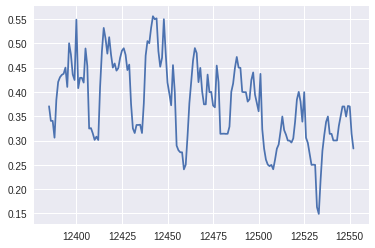

In [42]:
# plot 1 week of power prices
a = 12385
plt.plot(df['price'][a:a + 168])

In [0]:
# make lags
#lags = [1,2,3,7,14] # number of days
#lags = [1,2] # number of days
hours = 24
lags = [1,2,3,7] # number of days

for i in lags:
        col_name = 'lag' + str(i*hours)
        df[col_name] = df['price'].shift(i*hours)

In [44]:
idx = [0,1,23,24,25]
df.loc[idx]

,deliverydate,price,WIND_NL,lag24,lag48,lag72,lag168
0,2013-01-02 00:00:00+01:00,0.3406,0.3625,NaN,NaN,NaN,NaN
1,2013-01-02 01:00:00+01:00,0.3386,0.3875,NaN,NaN,NaN,NaN
23,2013-01-02 23:00:00+01:00,0.4368,0.3700,NaN,NaN,NaN,NaN
24,2013-01-03 00:00:00+01:00,0.3824,0.4150,0.3406,NaN,NaN,NaN
25,2013-01-03 01:00:00+01:00,0.3440,0.4425,0.3386,NaN,NaN,NaN


In [45]:
# remove rows with NaN
df.dropna(axis=0, how='any',inplace=True)
df.reset_index(drop=True,inplace=True)
df.head(2)

,deliverydate,price,WIND_NL,lag24,lag48,lag72,lag168
0,2013-01-09 00:00:00+01:00,0.4423,0.1875,0.5000,0.4255,0.4500,0.3406
1,2013-01-09 01:00:00+01:00,0.4356,0.2125,0.5101,0.3395,0.3307,0.3386


In [0]:
# split in train and test
idx_train = (df['deliverydate'].dt.year<=2016) & (df['deliverydate'].dt.year>=2014)
idx_test = df['deliverydate'].dt.year>=2017

df_train = df.loc[idx_train].reset_index(drop=True)
df_test = df.loc[idx_test].reset_index(drop=True)

In [47]:
df_test.head(2)

,deliverydate,price,WIND_NL,lag24,lag48,lag72,lag168
0,2017-01-01 00:00:00+01:00,0.4200,0.490,0.4180,0.3601,0.422,0.3400
1,2017-01-01 01:00:00+01:00,0.4994,0.495,0.4084,0.3596,0.393,0.2949


In [0]:
# select features from df
#features = ['lag24','lag48','lag168','lag336']
#features = ['lag24']
#features = ['lag24','lag48']
features = ['lag24','lag48','lag168']

X_train = df_train[features]
y_train = df_train['price']

In [49]:
# fit the model
lm = LinearRegression()  
lm.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
print(lm.coef_)
print(lm.intercept_)

[0.35432775 0.10695229 0.43169784]
0.0404056052440846


In [0]:
# Make predictions using the testing set
X_test = df_test[features]
y_pred = lm.predict(X_test)

In [52]:
# calc the mean squared error
mean_squared_error(df_train['price'], lm.predict(X_train))

0.0050178297998335385

In [53]:
# calc the mean absolute error
mean_absolute_error(df_test['price'], y_pred)*100

6.053186078592417

## Make model per weekday

In [0]:
df_test['pred'] = None

for i in [0,1,2,3,4,5,6]:
#for i in [0]:
  idx = df_train['deliverydate'].dt.weekday == i
  idx_test = df_test['deliverydate'].dt.weekday == i
  
  X_train = df_train.loc[idx,features]
  y_train = df_train.loc[idx,'price']
  
   # fit the model
  lm = LinearRegression()  
  lm.fit(X_train, y_train) 
  
  # Make predictions using the testing set
  X_test = df_test.loc[idx_test,features]
  y_pred = lm.predict(X_test)
  df_test.loc[idx_test,'pred'] = y_pred

In [55]:
# calc the mean absolute error
mean_absolute_error(df_test['pred'], df_test['price'])

0.057304081794670655

## Include wind

In [0]:
features = ['lag24','lag48','lag168','WIND_NL']

X_train = df_train[features]
y_train = df_train['price']

In [57]:
# fit the model
lm = LinearRegression()  
lm.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [58]:
print(lm.coef_)
print(lm.intercept_)

[ 0.33193903  0.10682326  0.44683797 -0.10458806]
0.06391820695098765


In [0]:
# Make predictions using the testing set
X_test = df_test[features]
y_pred = lm.predict(X_test)

In [60]:
# calc the mean squared error
mean_squared_error(df_train['price'], lm.predict(X_train))

0.004712417299148453

In [61]:
# calc the mean absolute error
mean_absolute_error(df_test['price'], y_pred)*100

5.982786477942622

## Wind per weekday

In [0]:
df_test['pred'] = None

for i in [0,1,2,3,4,5,6]:
#for i in [0]:
  idx = df_train['deliverydate'].dt.weekday == i
  idx_test = df_test['deliverydate'].dt.weekday == i
  
  X_train = df_train.loc[idx,features]
  y_train = df_train.loc[idx,'price']
  
   # fit the model
  lm = LinearRegression()  
  lm.fit(X_train, y_train) 
  
  # Make predictions using the testing set
  X_test = df_test.loc[idx_test,features]
  y_pred = lm.predict(X_test)
  df_test.loc[idx_test,'pred'] = y_pred

In [63]:
# calc the mean absolute error
mean_absolute_error(df_test['pred'], df_test['price'])*100

5.662037612406183